In [1]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

import covalent as ct


from covalent.executor import DaskExecutor
from dask.distributed import LocalCluster


np.random.seed(42)

# Load, preprocess and split data

We use the Iris dataset in this tutorial. We do some necessary preprocessing on the data and split them into training and test dataset.

In [2]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

In [3]:
n_qubits = len(X_train[0])

dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@ct.electron()
@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [4]:
@ct.electron()
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

@ct.electron()
def fit_SVC(X_train, y_train,kernel_matrix):
    svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)
    return svm

@ct.electron()
def predict_SVC(svm, X_test):
    predictions = svm.predict(X_test)
    return predictions

@ct.electron()
def get_accuracy_score(predictions, y_test):
    return accuracy_score(predictions, y_test)


In [29]:
@ct.lattice()
def kernel_workflow(X_train, y_train, X_test, y_test, kernel_matrix):
    svm = fit_SVC(X_train, y_train, kernel_matrix)
    predictions = predict_SVC(svm,X_test)
    acc = get_accuracy_score(predictions, y_test)
    return acc

In [30]:
kernel_workflow(X_train, y_train, X_test, y_test, kernel_matrix)

1.0

In [31]:
dispatch_id = ct.dispatch(kernel_workflow)(X_train, y_train, X_test, y_test, kernel_matrix)

In [34]:
kernel_result = ct.get_result(dispatch_id=dispatch_id, wait=True)
kernel_result.result

1.0

In [7]:
dev_kernel.num_executions

7500

In [9]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

circuit_evals_kernel(n_data=len(X), split=len(X_train) /(len(X_train) + len(X_test)))

7500

In [5]:
dev_var = qml.device("default.qubit", wires=n_qubits)

@ct.electron()
@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AngleEmbedding(x, wires=range(n_qubits))

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

@ct.electron()
def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

@ct.electron()
def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [10]:
@ct.electron()
def get_params(n_layers):
    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)
    return params_torch, bias_torch

@ct.electron()
def get_optimizer(params_torch, bias_torch):
    return torch.optim.Adam([params_torch, bias_torch], lr=0.1)

@ct.electron()
def get_batch_data(batch_ids):
    X_batch = X_train[batch_ids]
    y_batch = y_train[batch_ids]

    X_batch_torch = torch.tensor(X_batch, requires_grad=False)
    y_batch_torch = torch.tensor(y_batch, requires_grad=False)
    
    return X_batch_torch, y_batch_torch


@ct.electron()
def step_optimizer(opt, params_torch, bias_torch,  X_batch_torch, y_batch_torch):
    def closure():
        opt.zero_grad()
        preds = torch.stack(
            [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
        )
        loss = torch.mean(hinge_loss(preds, y_batch_torch))

        # bookkeeping
        current_loss = loss.detach().numpy().item()
        #loss_history.append(current_loss)
#         if i % 10 == 0:
#             print("step", i, ", loss", current_loss)

        loss.backward()
        return loss

    opt.step(closure)
    current_loss = closure().detach().numpy().item()
    return opt, current_loss

@ct.lattice()
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""
    
    params_torch, bias_torch = get_params(n_layers)

    opt = get_optimizer(params_torch, bias_torch)

    loss_history = []
    
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch_torch, y_batch_torch = get_batch_data(batch_ids)

        opt = get_optimizer(params_torch, bias_torch)       
        
        opt, current_loss = step_optimizer(opt = opt,params_torch = params_torch, bias_torch = bias_torch,  X_batch_torch = X_batch_torch, y_batch_torch = y_batch_torch)
        
        loss_history.append(current_loss)
        
    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

In [13]:
quantum_model_train(n_layers, 10, batch_size)

(tensor([[[ 0.7654, -0.2417,  0.8826],
          [ 1.1887,  1.0789,  0.7004],
          [ 0.0467,  0.0563,  0.8045],
          [ 1.2878,  0.6509,  1.3356]],
 
         [[ 0.7853,  0.6690,  0.5807],
          [ 0.3723,  0.9401,  0.9737],
          [ 0.8839, -0.2946,  0.4856],
          [ 0.4484,  0.9945,  0.1759]]], dtype=torch.float64,
        requires_grad=True),
 tensor(0.),
 [1.1608638861071854,
  1.1235740413714765,
  1.0215479383172477,
  0.995945419614604,
  0.9369307976963229,
  0.9456064940022142,
  0.8666741847975062,
  0.7444601105128636,
  0.7178592950999982,
  0.7969971780418705])

In [12]:
n_layers = 2
batch_size = 20
steps = 1
dispatch_id = ct.dispatch(quantum_model_train)(n_layers, steps, batch_size)

step 0 , loss 1.2128428849025235
step 10 , loss 0.8582750956106431
step 20 , loss 0.4384989057963321
step 30 , loss 0.6458829274590641
step 40 , loss 0.5540116701446126
step 50 , loss 0.4132239145818268
step 60 , loss 0.5209433003814097
step 70 , loss 0.4694193423160378
step 80 , loss 0.4858145744021141
step 90 , loss 0.41962346215340246
accuracy on test set: 0.96


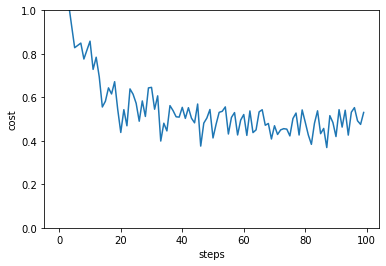

In [12]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [13]:
def circuit_evals_variational(n_data, n_params, n_steps, shift_terms, split, batch_size):
    """Compute how many circuit evaluations are needed for
       variational training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_params * n_steps * batch_size * shift_terms
    n_prediction = Mpred

    return n_training + n_prediction

circuit_evals_variational(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    shift_terms=2,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

96025

In [14]:
def model_evals_nn(n_data, n_params, n_steps, split, batch_size):
    """Compute how many model evaluations are needed for neural
       network training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_steps * batch_size
    n_prediction = Mpred

    return n_training + n_prediction

model_evals_nn(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

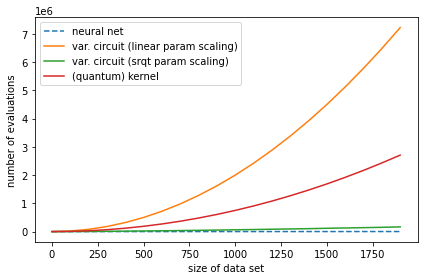

In [15]:
variational_training1 = []
variational_training2 = []
kernelbased_training = []
nn_training = []
x_axis = range(0, 2000, 100)

for M in x_axis:

    var1 = circuit_evals_variational(
        n_data=M, n_params=M, n_steps=M,  shift_terms=2, split=0.75, batch_size=1
    )
    variational_training1.append(var1)

    var2 = circuit_evals_variational(
        n_data=M, n_params=round(np.sqrt(M)), n_steps=M,
        shift_terms=2, split=0.75, batch_size=1
    )
    variational_training2.append(var2)

    kernel = circuit_evals_kernel(n_data=M, split=0.75)
    kernelbased_training.append(kernel)

    nn = model_evals_nn(
        n_data=M, n_params=M, n_steps=M, split=0.75, batch_size=1
    )
    nn_training.append(nn)


plt.plot(x_axis, nn_training, linestyle='--', label="neural net")
plt.plot(x_axis, variational_training1, label="var. circuit (linear param scaling)")
plt.plot(x_axis, variational_training2, label="var. circuit (srqt param scaling)")
plt.plot(x_axis, kernelbased_training, label="(quantum) kernel")
plt.xlabel("size of data set")
plt.ylabel("number of evaluations")
plt.legend()
plt.tight_layout()
plt.show()